In [1]:
# wavio.py
# Author: Warren Weckesser
# License: BSD 3-Clause (http://opensource.org/licenses/BSD-3-Clause)

import wave
% pylab inline


def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.fromstring(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result


def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array


def writewav24(filename, rate, data):
    """Create a 24 bit wav file.
    data must be "array-like", either 1- or 2-dimensional.  If it is 2-d,
    the rows are the frames (i.e. samples) and the columns are the channels.
    The data is assumed to be signed, and the values are assumed to be
    within the range of a 24 bit integer.  Floating point values are
    converted to integers.  The data is not rescaled or normalized before
    writing it to the file.
    Example: Create a 3 second 440 Hz sine wave.
    >>> rate = 22050  # samples per second
    >>> T = 3         # sample duration (seconds)
    >>> f = 440.0     # sound frequency (Hz)
    >>> t = np.linspace(0, T, T*rate, endpoint=False)
    >>> x = (2**23 - 1) * np.sin(2 * np.pi * f * t)
    >>> writewav24("sine24.wav", rate, x)
    """
    a32 = np.asarray(data, dtype=np.int32)
    if a32.ndim == 1:
        # Convert to a 2D array with a single column.
        a32.shape = a32.shape + (1,)
    # By shifting first 0 bits, then 8, then 16, the resulting output
    # is 24 bit little-endian.
    a8 = (a32.reshape(a32.shape + (1,)) >> np.array([0, 8, 16])) & 255
    wavdata = a8.astype(np.uint8).tostring()

    w = wave.open(filename, 'wb')
    w.setnchannels(a32.shape[1])
    w.setsampwidth(3)
    w.setframerate(rate)
    w.writeframes(wavdata)
    w.close()

Populating the interactive namespace from numpy and matplotlib


48000 3


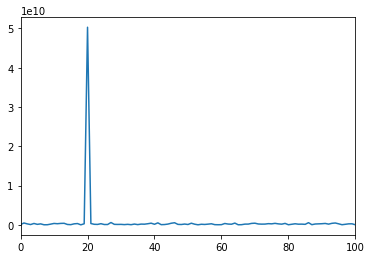

In [24]:
from scipy.fftpack import fft

def find_peak (path):
    rate, sampwidth, data = readwav(path)
    print(rate, sampwidth)
    a = data.T[0] # this is a two channel soundtrack, I get the first track
    half_sec = a[:rate//2] # first half second
    # b=[(ele/2**8.)*2-1 for ele in a] # this is 8-bit track, b is now normalized on [-1,1)
    c = fft(half_sec) # calculate fourier transform (complex numbers list)
    d = len(c)/2  # you only need half of the fft list (real signal symmetry)
    plt.xlim((0,100))
    plot(abs(c[:int(d-1)]))


find_peak('stimuli/ASSRStim.wav')
#find_peak('stimuli/ASSR_20sec.wav')